In [1]:
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import math

import c2qa
import c2qa.util
import c2qa.wigner
import matplotlib.pyplot
import numpy
import qiskit
import qiskit_aer

## Displacement Gate Calibration
The following circuit is a way to calibrate the conditional displacement gate. 

In [3]:
def calibration_circuit(dist, num_qumodes = 1, num_qubits_per_qumode = 4):
    qmr = c2qa.QumodeRegister(num_qumodes=num_qumodes, num_qubits_per_qumode=num_qubits_per_qumode)
    qr = qiskit.QuantumRegister(size=1)
    cr = qiskit.ClassicalRegister(size=1)
    circuit = c2qa.CVCircuit(qmr, qr, cr)

    circuit.initialize([1,0], qr[0])
    circuit.cv_initialize(0, qmr[0])

    circuit.h(qr[0])
    circuit.cv_c_d(dist, qmr[0], qr[0])
    circuit.cv_d(1j * dist, qmr[0])
    circuit.cv_c_d(-dist, qmr[0], qr[0])
    circuit.cv_d(-1j * dist, qmr[0])
    circuit.h(qr[0])
    circuit.measure(qr[0], cr[0])

    return circuit, qr[0], cr[0]

## Simulate one shot to plot Wigner function 
The statevector_simulator produces a state vector output. Then use the state vector to plot the Wigner function using the c2qa.util module.

In [4]:
circuit, _, _  = calibration_circuit(numpy.sqrt(numpy.pi) / numpy.sqrt(2))
state, result, fock_counts = c2qa.util.simulate(circuit)
counts = result.get_counts(circuit)

print("Simulated statevector:")
print(state)
print("Simulated result counts:")
print(counts)

Simulated statevector:
Statevector([-9.99999967e-01+6.12323305e-17j,
              7.60483041e-23+1.41499239e-06j,
             -6.78787254e-06+4.67039003e-22j,
             -5.92694664e-22-8.74957992e-06j,
             -2.80769767e-05+4.12048164e-21j,
             -6.85593988e-21-1.07346996e-04j,
              9.49687008e-05-8.58671221e-21j,
             -5.76523103e-21-6.76692002e-05j,
              8.63810684e-05-4.84314552e-21j,
             -1.68924967e-21-7.18481148e-05j,
             -1.68382058e-05-1.06756320e-21j,
             -4.04154659e-21-8.43754939e-05j,
             -7.49838561e-05+9.00401067e-21j,
              1.32134855e-21+2.08858618e-05j,
              3.15316355e-05+1.82645417e-21j,
              6.16867254e-21+1.09546757e-04j,
              0.00000000e+00+0.00000000e+00j,
             -0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
             -0.00000000e+00+0.00000000e+00j,
              0.00000000e+00-0.00000000e+00j,
           

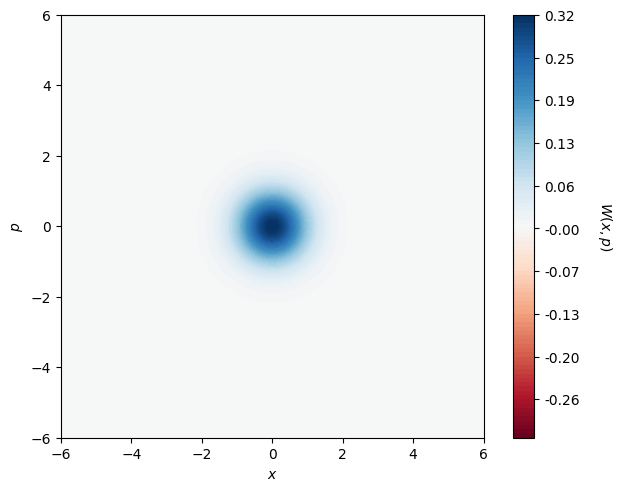

In [5]:
# Plot Fock state Wigner function
c2qa.wigner.plot_wigner(circuit, state)

## Iterate over incremental displacements
Iteratively simulate the calibration cicruit with incremental differences in the displacement and plot probability difference results.

In [6]:
# Run the simulations
backend = qiskit_aer.Aer.get_backend("qasm_simulator")
up = numpy.linspace(numpy.sqrt(2), 2, 20)
down = numpy.linspace(2, numpy.sqrt(2), 20)
steps = []

for _ in range(2):
    steps.extend(up[0:19])
    steps.extend(down[0:19])

x = []
y = []

for i, step in enumerate(steps):
    dist = numpy.sqrt(numpy.pi) / step
    circuit, _, _ = calibration_circuit(dist)

    state, result, fock_counts = c2qa.util.simulate(circuit, shots=32)
    counts = result.get_counts(circuit)

    x.append(i)
    y.append(counts.get("0", 0) - counts.get("1", 0))

    print(f"{i}: {counts}")

0: {'0': 32}
1: {'0': 32}
2: {'0': 30, '1': 2}
3: {'0': 30, '1': 2}
4: {'0': 29, '1': 3}
5: {'1': 13, '0': 19}
6: {'1': 10, '0': 22}
7: {'0': 18, '1': 14}
8: {'0': 12, '1': 20}
9: {'1': 18, '0': 14}
10: {'1': 25, '0': 7}
11: {'1': 23, '0': 9}
12: {'1': 27, '0': 5}
13: {'1': 27, '0': 5}
14: {'1': 30, '0': 2}
15: {'1': 30, '0': 2}
16: {'1': 32}
17: {'1': 32}
18: {'1': 32}
19: {'1': 32}
20: {'1': 32}
21: {'1': 31, '0': 1}
22: {'1': 32}
23: {'1': 32}
24: {'1': 31, '0': 1}
25: {'1': 28, '0': 4}
26: {'1': 27, '0': 5}
27: {'1': 25, '0': 7}
28: {'1': 21, '0': 11}
29: {'1': 22, '0': 10}
30: {'1': 19, '0': 13}
31: {'1': 16, '0': 16}
32: {'0': 20, '1': 12}
33: {'0': 21, '1': 11}
34: {'0': 25, '1': 7}
35: {'0': 30, '1': 2}
36: {'0': 32}
37: {'0': 32}
38: {'0': 32}
39: {'0': 31, '1': 1}
40: {'0': 30, '1': 2}
41: {'1': 8, '0': 24}
42: {'0': 28, '1': 4}
43: {'0': 20, '1': 12}
44: {'1': 15, '0': 17}
45: {'1': 15, '0': 17}
46: {'1': 18, '0': 14}
47: {'0': 15, '1': 17}
48: {'1': 23, '0': 9}
49: {'1': 27

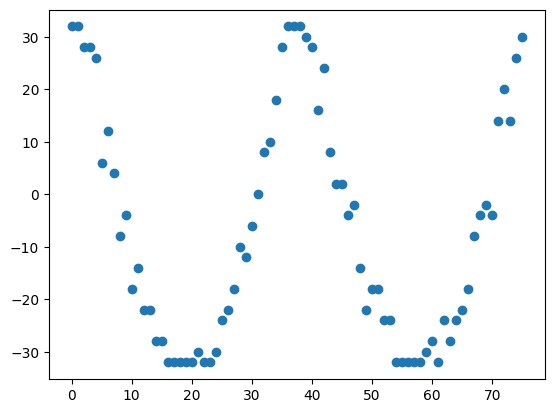

In [7]:
# Plot the results
matplotlib.pyplot.scatter(x, y)
matplotlib.pyplot.show()

## Animate the circuit

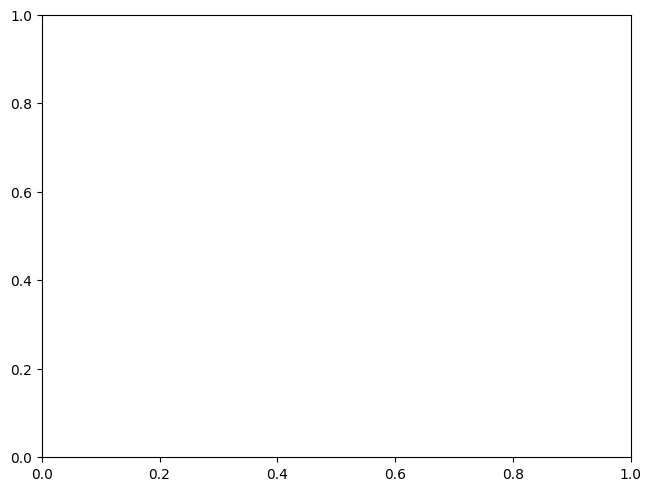

In [8]:
circuit, qubit, cbit  = calibration_circuit(dist=numpy.sqrt(numpy.pi) / numpy.sqrt(2))

anim = c2qa.animate.animate_wigner(circuit, qubit=qubit, cbit=cbit, animation_segments=10, shots=10)

In [9]:
from IPython.display import HTML
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available